In [6]:
from src.datasets.librispeech_dataset import LibrispeechDataset
from src.text_encoder.ctc_text_encoder import CTCTextEncoder
import torchaudio
from src.transforms import Logarithm, Normalize1D   
from torch import nn
from src.model.utils import Transpose

dataset = LibrispeechDataset("test-clean", text_encoder=CTCTextEncoder(), instance_transforms={
    "get_spectrogram": torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=80),
    "spectrogram": nn.Sequential(Logarithm(), Transpose(-2, -1), Normalize1D("normalization_params.json", "cpu"), Transpose(-2, -1))
})
clean_dataset = LibrispeechDataset("test-clean", text_encoder=CTCTextEncoder(), instance_transforms={
    "get_spectrogram": torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=80),
    "spectrogram": Logarithm()
})

In [2]:
dataset[0]

{'audio': tensor([[ 0.0015,  0.0020,  0.0016,  ..., -0.0060, -0.0162, -0.0254]]),
 'spectrogram': tensor([[[ 1.5862e-01,  1.5898e-01, -6.1167e-01,  ..., -2.5658e-01,
           -2.6939e-01, -5.9402e-01],
          [ 2.9900e-01,  2.9879e-01, -1.2623e+00,  ..., -3.8320e-01,
           -5.1133e-01, -3.2296e-01],
          [-1.3436e-02, -1.2368e-02, -4.1205e-01,  ..., -1.1868e-01,
           -2.1070e-01, -3.0277e-01],
          ...,
          [ 1.1416e+00,  1.1380e+00,  3.7344e-02,  ..., -5.7395e-02,
           -3.0384e-02,  1.8997e-01],
          [ 1.0734e+00,  1.0700e+00,  3.1027e-01,  ...,  1.7465e-01,
           -1.4871e-02, -3.2122e-02],
          [ 1.2470e+00,  1.2429e+00, -3.2828e-01,  ...,  1.2541e-01,
            8.8358e-04,  1.3954e-01]]]),
 'text': 'a story',
 'text_encoded': tensor([[ 1., 27., 19., 20., 15., 18., 25.]]),
 'audio_path': '/home/ubuntu/asr-rnn-t/data/datasets/librispeech/test-clean/672/122797/672-122797-0033.flac'}

In [2]:
max([len(i['audio'][0]) for i in dataset])

559280

In [2]:
dataset[0]

{'audio': tensor([[ 0.0015,  0.0020,  0.0016,  ..., -0.0060, -0.0162, -0.0254]]),
 'spectrogram': tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [4.3127e-03, 6.9828e-03, 1.7415e-03,  ..., 2.9436e-01,
           1.4783e-01, 2.1176e-01],
          [2.3221e-02, 3.7597e-02, 9.3769e-03,  ..., 1.5849e+00,
           7.9596e-01, 1.1402e+00],
          ...,
          [3.9871e-05, 1.8696e-05, 4.0781e-05,  ..., 2.2813e-05,
           7.9833e-05, 6.3455e-05],
          [1.0160e-05, 3.7172e-05, 2.6600e-05,  ..., 1.0153e-04,
           1.7639e-04, 9.2710e-05],
          [6.5683e-06, 3.3872e-05, 1.6014e-05,  ..., 1.1362e-04,
           2.4385e-04, 1.1336e-04]]]),
 'text': 'a story',
 'text_encoded': tensor([[ 1., 27., 19., 20., 15., 18., 25.]]),
 'audio_path': '/Users/vovasenev/hse/DLA/asr/data/datasets/librispeech/test-clean/672/122797/672-122797-0033.flac'}

In [11]:
from src.datasets.librispeech_dataset import LibrispeechDataset
from src.text_encoder import RNNTTextEncoder
import torchaudio
import numpy as np
import json
from tqdm import tqdm
from src.transforms.spec_augs.logarithm import Logarithm

dataset = LibrispeechDataset("train_all", text_encoder=RNNTTextEncoder(), shuffle_index=True, instance_transforms={
    "get_spectrogram": torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=80),
    "spectrogram": Logarithm()
})

all_spectrograms = []

i = 0

for item in tqdm(dataset):
    if i == 10000:
        break
    all_spectrograms.append(item['spectrogram'][0])
    i += 1



  4%|▎         | 10000/281241 [00:57<25:53, 174.59it/s]


In [12]:
import torch

all_spectrograms = torch.cat(all_spectrograms, dim=-1)

In [23]:
mean = torch.mean(all_spectrograms, dim=1).tolist()
std = torch.std(all_spectrograms, dim=1).tolist()

json.dump({'mean': mean, 'std': std}, open('normalization_params.json', 'w'), indent=4)

In [22]:
mean

[-5.734709739685059,
 -4.452139854431152,
 -4.455965042114258,
 -4.558087348937988,
 -3.3392019271850586,
 -3.3397347927093506,
 -3.2621264457702637,
 -2.708282709121704,
 -3.079345226287842,
 -3.0732357501983643,
 -3.535551071166992,
 -3.628387212753296,
 -3.565392017364502,
 -3.431000232696533,
 -3.4473838806152344,
 -3.5632119178771973,
 -3.7453341484069824,
 -3.957963466644287,
 -4.205967426300049,
 -4.488927364349365,
 -4.765824317932129,
 -5.002224445343018,
 -5.182253837585449,
 -5.3333964347839355,
 -5.483791351318359,
 -5.593530654907227,
 -5.5867743492126465,
 -5.913296699523926,
 -6.007710933685303,
 -5.843991756439209,
 -6.200894355773926,
 -6.022568702697754,
 -6.1734185218811035,
 -5.9528021812438965,
 -5.964899063110352,
 -5.889049530029297,
 -5.9094696044921875,
 -5.8836188316345215,
 -5.862020492553711,
 -5.885225296020508,
 -5.936222553253174,
 -5.998152732849121,
 -6.051261901855469,
 -6.114333629608154,
 -6.168697357177734,
 -6.186513423919678,
 -6.12221097946167,
 

In [5]:
dataset[0]['spectrogram'][0].shape

torch.Size([80, 84])

could only be decided on the spot


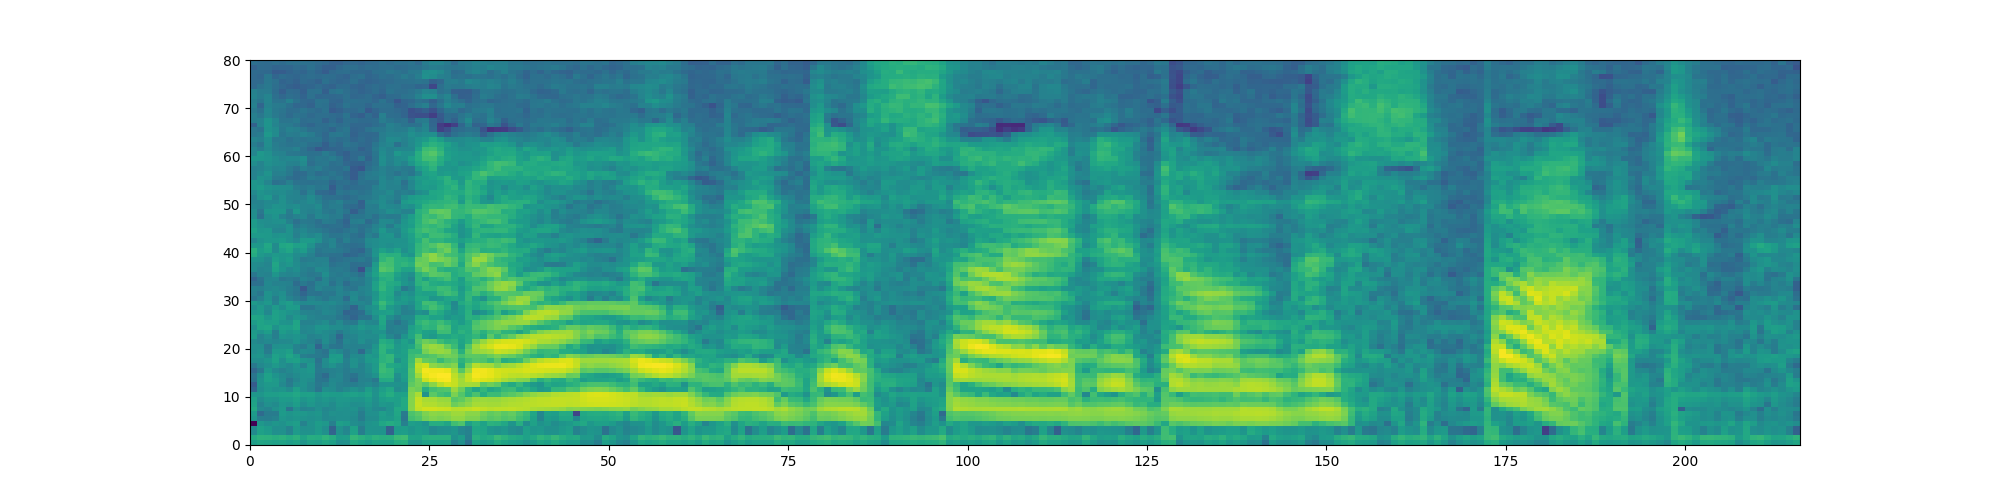

In [3]:
from src.logger.utils import plot_spectrogram

i = 1398
print(dataset[i]['text'])
plot_spectrogram(dataset[i]['spectrogram'][0])